# PROJECT: Course Optimization for Data Science
## Optimization strategies for Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Stéphane Gaiffas

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the without intercept case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 3rd of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last name
fn1 = "sophia"
ln1 = "lazraq"


filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1])) + ".ipynb"
print(filename)


project_lazraq_sophia.ipynb


Some imports

In [233]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`pip install cvxopt`

if you have `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: SVM Classification with linear kernel

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

### Questions

- Q1: Justify that the problem $(\mathcal{P})$ is convex.

**ANSWER Q1**


A problem is convex if the objective function and feasible set are convex

- The objective $\phi(w,b) = \frac{1}{2}w^{\top}w$ of the problem $(\mathcal{P})$  is a quadratic, definite positive, therefore it is convex.
- The feasible set : {(w,b) | $y_{i}(w^{\top}x_{i}+b)\geq 1$} is convex for each i since the expression $y_{i}(w^{\top}x_{i}+b)\ - 1$ is affine for each i.

** Conclusion: The problem $(\mathcal{P})$ is convex **

- Q2: By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

I will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

**ANSWER Q2**

Let's show that the dual of the problem $(\mathcal{P})$ is $(\mathcal{D})$

$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

We showed that $\mathcal{P}$ is convex. Applying the KKT theorem, there exists saddle points $(w^{*}, \mu^{*})$ such that $w^{*}$ is solution to the primal and $\mu^{*}$ is solution to the dual.

We have  $\forall i\in \{1,\cdots,n\}  $ 
$$\mathcal{L}(w, b, \mu) = \frac{1}{2}w^{\top}w + \sum_{i=1}^{n} \mu_i[- y_{i}(w^{\top}x_{i}+b) + 1] , where ~\mu_i \geq 0 \quad  $$

$ \forall i\in \{1,\cdots,n\} ~we~have ~ \mu_i \geq 0. $  It implies that $ -\mu_i \leq 0 $ thus -$\mu \leq 0$

Since we want to solve $\max\min_{w,b} L(w,b,\mu)$ , we derive with respect to w and b : 

$$
\begin{cases}
\frac{d\mathcal{L}(w, b, \mu)}{dw} = w + \sum_{i=1}^{n} -\mu_iy_{i}x_{i} = 0 ~(1) \\
\frac{d\mathcal{L}(w, b, \mu)}{db} = \sum_{i=1}^{n} -\mu_iy_{i} = 0 ~(2)
\end{cases}
$$


We deduce from (1) that $w = \sum_{i=1}^{n} \mu_iy_{i}x_{i}$. In terms of matrix, it gives us $w = G^{\top}\mu$ where $G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}$ and $\mu = \begin{bmatrix} \mu_{1} \\ \vdots \\ \mu_{n}\end{bmatrix}$

We deduce from (2) that  $y^{\top}\mu = 0 $ where $y = \begin{bmatrix} y_{1} \\ \vdots \\ y_{n}\end{bmatrix}$

We have : $$\mathcal{L}(w, b, \mu) = \frac{1}{2}w^{\top}w + \sum_{i=1}^{n} \mu_i[- y_{i}(w^{\top}x_{i}+b) + 1]$$

By simplifying : $$\mathcal{L}(w, b, \mu) = \frac{1}{2}w^{\top}w - \sum_{i=1}^{n} \mu_i y_{i}w^{\top}x_{i} - \sum_{i=1}^{n} \mu_i y_{i}b + \sum_{i=1}^{n} \mu_i $$

By replacing $w = \sum_{i=1}^{n} \mu_iy_{i}x_{i}$ in $\mathcal{L}(w, b, \mu)$, we get : $$\mathcal{L}(\mu) = \frac{1}{2}w^{\top}w - w^{\top}w - \sum_{i=1}^{n} \mu_i y_{i}b + \sum_{i=1}^{n} \mu_i $$

We also have : $\sum_{i=1}^{n} \mu_iy_{i} = 0$, thus we get: $$\mathcal{L}(\mu) = - \frac{1}{2}w^{\top}w + \sum_{i=1}^{n} \mu_i $$

Eventually: $\mathcal{L}(\mu) = - \frac{1}{2}\mu^{\top}GG^{\top}\mu + \mu^{\top} u $ where $u = (1, \dots, 1) \in \mathbb{R}^n $

Our dual problem can then be written as:

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \max_{\mu} &-\frac{1}{2}\mu^{\top}GG^{t}\mu+\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$


Which is equivalent to :

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$


- Q3: Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:

$$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$

** ANSWER Q3 **

We know that the prediction function is equal to  : $f(x)=\mathrm{sign}(w^{\top}x + b)$. 

From the previous question, we got , $w = \sum_{i=1}^{n} \mu_i y_{i}x_{i}$. 

Therefore $$y = f(x) = \mathrm{sign}(\sum_{i=1}^{n} \mu_iy_{i}x^{\top}_{i}x + b)$$

## Part 1: Implementation of solver with intercept using cvxopt

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [234]:
from svm_project_utils import plot_dataset, datasets

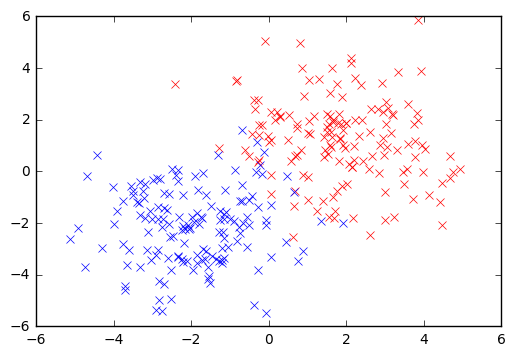

In [235]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [236]:
import cvxopt

def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [237]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

### Questions

- Q4: Modify the following cell to solve the SVM dual problem:

By taking the transpose of the objective $  \min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x $ , we get $  \min_{(x)} \frac{1}{2}x^{\top} H^\top x -  x^\top e $.
By correspondance, we obtain:
$$
\left\{
  \begin{array}{cll}
  &x=\mu
  \\
   & A= y
   \\
   & b = 0
   \\
   & H = G G^\top  
  \end{array}
  \right.
$$


Number of support vectors is equal to 3


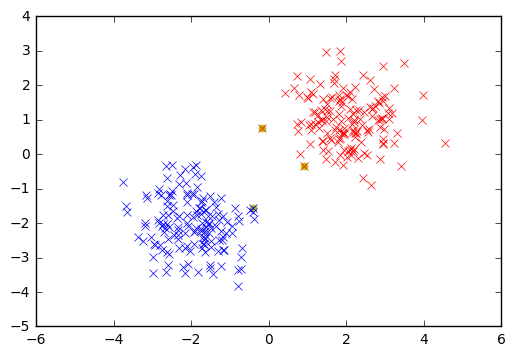

In [238]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
plot_dataset(X, y)

def svm_solver(K, y, C=np.inf):
    H = (y*K).T * y
    #print(H)
    e = np.ones(y.shape[0])
    A = y
    b = 0
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    print("Number of support vectors is equal to %s" %idx_support.size)
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
#print("Number of support vectors: %s" % idx_support.size)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color='y')


- Q5: Compute w from mu and b

I proved previously that $w = \sum_{i=1}^{n} \mu_iy_{i}x_{i}$.

In [239]:
def compute_w(mu_sup,idx_sup):
    w = np.sum((mu_sup * y[idx_sup])[: , None] * X[idx_sup],axis =0)
    return w

w = compute_w(mu_support,idx_support)
print(w)

[ 0.79978975  0.7748421 ]


- Q6: Using complementary slackness, explain how to obtain $b$ from $\mu$.

HINT: Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.





Applying the complementary slackness KKT condition, we have:

$ \mu_i(y_{i}(w^{t}x_{i}+b) - 1) = 0 $ for all points i of the dataset.

Moreover, given a support vector i, $\mu_i > 0$ . It implies $y_{i}(w^{t}x_{i}+b) - 1 = 0$

Each $ y_i $ takes two possibles values: $y_i\in\{-1,+1\}$:

$$
\left\{
  \begin{array}{cll}
  &b = 1 - w^{t}x_{i} \; \; \; \; \; \; \; \; if \;  y_i = 1  
  \\
   & b = -1 - w^{t}x_{i} \; \; \; \; \; \; \; \; if \;  y_i = -1
  \end{array}
  \right.
$$

Wich can be written in one expression as:

$$ b = y_i - w^{t}x_{i} $$

From a previous question, we know that $w = G^{T}\mu = \sum_{i=1}^{n} y_j \mu_j x_j$, thus: 

$$b = y_i - \sum_{i=1}^{n} y_j \mu_j x_j^T x_i$$ where $i$ is any support vector.

In [240]:
def compute_b(K, y, mu_support, idx_support):
    y_support = y[idx_support]
    K_support = K[idx_support][:, idx_support]
    b = y_support[0]- np.sum(y_support*mu_support*K_support[0,:])
    return b

b = compute_b(K, y, mu_support, idx_support)
print("b= %s"  % b)

b= 0.545154252853


- Q7: Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:

$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.

In [241]:
#Using matrix expression and checking that every term of the matrix is positive
n = 300
is_pos = y *np.dot(X, w) + y*b*np.ones(n) - 1 + 1e-5
print("For every i , is the constraint respected ? : %s" % np.all(is_pos >= 0))

For every i , is the constraint respected ? : True


Check your code by running the following cell:

Number of support vectors is equal to 3


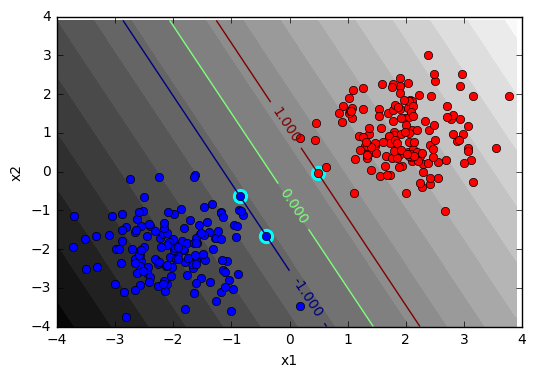

In [242]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plot_classif(X, y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'cyan', s =100)

I will now change the value of $\sigma$ such that the problem is not linearily separable anymore.

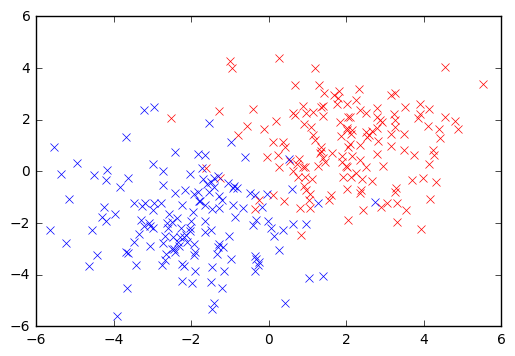

In [243]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [244]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

Terminated (singular KKT matrix).
Number of support vectors is equal to 300


- Q8: Check that contraints of the problem are now violated.

For every i , is the constraint respected ? : False


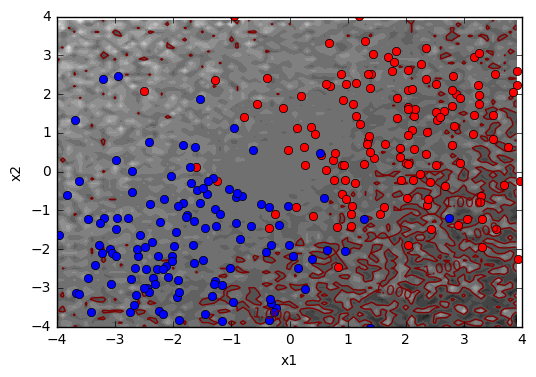

In [245]:
#Using matrix expression and checking that every term of the matrix is positive
is_pos = y * (np.dot(X, w) + b*np.ones(n)) - 1 + 1e-5
print("For every i , is the constraint respected ? : %s" % np.all(is_pos >= 0))

#case is not separable anymore (plot)
plot_classif(X, y, mu_support, idx_support, b)

## Part 1: Non separable case with cvxopt

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

### Questions

- Q9: Justify that $(P_{s})$ is a convex problem

**ANSWER Q9**


A problem is convex if the objective function and feasible set are convex

- The objective $\phi(w,b,\xi) = \frac{1}{2}w^{\top}w + C \sum_i \xi_i $ of the problem $P_{s}$ is a quadratic and semi-definite positive function, thus it is convex.
- Feasible set : {(w,b,$\xi$) | $y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 $} is also convex since it is affine.


- Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

- Let's show that the dual of the problem $P_{S}$ is $(\mathcal{D})$

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$


We write the lagrangian as follows:

$\mathcal{L}(w, b, \mu, \xi, \alpha)$ = $\frac{1}{2}w^{\top}w + C \sum_i \xi_i + \sum_{i=1}^{n} \mu_i[- y_{i}(w^{\top}x_{i}+b) + 1 - \xi_{i}] - \sum_i \alpha_i \xi_i$ where $\mu_i \geq 0$ and $\alpha_i \geq 0 \quad \forall i\in \{1,\cdots,n\} $

 We have $\mu_i \geq 0 $ thus $\mu \geq 0$

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\frac{d\mathcal{L}(w, b, \mu, \xi, \alpha)}{dw} = w + \sum_{i=1}^{n} -\mu_iy_{i}x_{i} = 0 \;\;\;\;\; (1)
\\
\frac{d\mathcal{L}(w, b, \mu, \xi, \alpha)}{db} = \sum_{i=1}^{n} -\mu_iy_{i} = 0  \;\;\;\;\; \;\;\;\;\; \;\;\;(2)
\\
\frac{d\mathcal{L}(w, b, \mu, \xi, \alpha)}{d\xi_{i}} = C - \alpha_{i} - \mu_{i} = 0   \;\;\;\;\; \;\;\;\;\;\;\; (3)
\end{array}
\right .
$$


From (1) we get $w = \sum_{i=1}^{n} \mu_iy_{i}x_{i}$ . Therefore $w = G^{\top}\mu$ where $G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}$ and $\mu = \begin{bmatrix} \mu_{1} \\ \vdots \\ \mu_{n}\end{bmatrix}$


From (2)  we get $y^{\top}\mu = 0 $ où $y = \begin{bmatrix} y_{1} \\ \vdots \\ y_{n}\end{bmatrix}$

From (3) we get $ \mu_{i} = C - \alpha_{i}$. Since $\alpha_{i} \geq 0 $ then $\mu_{i} \leq C $. Therefore, $0 \leq \mu \leq C$


Let us go back to the lagrangian  :

$$\mathcal{L}(w, b, \mu, \xi, \alpha) = \frac{1}{2}w^{\top}w + C \sum_i \xi_i + \sum_{i=1}^{n} \mu_i[- y_{i}(w^{\top}x_{i}+b) + 1 - \xi_{i}] - \sum_i \alpha_i \xi_i$$

$$\mathcal{L}(w, b, \mu, \xi, \alpha) = \frac{1}{2}w^{\top}w - \sum_{i=1}^{n} \mu_i y_{i}w^{\top}x_{i} - \sum_{i=1}^{n} \mu_i y_{i}b + \sum_{i=1}^{n} \mu_i + \sum_{i}^{n} \xi_{i}(C - \mu_{i} - \alpha_{i})$$

We got previously $ \mu_{i} = C - \alpha_{i}$, it implies $$\mathcal{L}(w, b, \mu, \xi, \alpha) = \frac{1}{2}w^{\top}w - \sum_{i=1}^{n} \mu_i y_{i}w^{\top}x_{i} - \sum_{i=1}^{n} \mu_i y_{i}b + \sum_{i=1}^{n} \mu_i $$

By replacing $w = \sum_{i=1}^{n} \mu_iy_{i}x_{i}$ in $\mathcal{L}(w, b, \mu, \xi, \alpha)$, we get :

$$\mathcal{L}(\mu) = \frac{1}{2}w^{\top}w - w^{\top}w - \sum_{i=1}^{n} \mu_i y_{i}b + \sum_{i=1}^{n} \mu_i $$

Since $\sum_{i=1}^{n} \mu_iy_{i} = 0$, we get: $\mathcal{L}(\mu) = - \frac{1}{2}w^{\top}w + \sum_{i=1}^{n} \mu_i $

Then: $\mathcal{L}(\mu) = - \frac{1}{2}\mu^{\top}GG^{\top}\mu + \mu^{\top} u $ where $u = (1, \dots, 1) \in \mathbb{R}^n $

Therefore, we can write the Dual problem as follow:

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& 0 \leq \mu \leq C
 \end{array}
 \right .
$$



- Q10: Modify your code from Q4 to handle the non-separable case.

** Since the dataset is generated randomly, we plot it once and then we use the same dataset for which we apply different values of C to understand its influence **

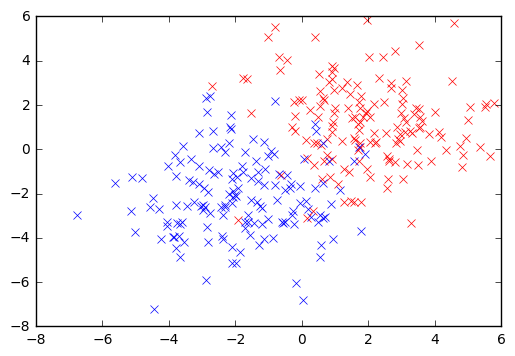

In [246]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
plot_dataset(X, y)

In the non separable case, we have the constraint $\mu < C$ for each i, so we have to recompute the intercept taking into account this constraint such that $\mu_i < C$.

In [247]:
def b_non_separable(K, y, mu_support, idx_support, C):
    mu = np.zeros(K.shape[0])
    mu[idx_support] = mu_support 
    i = idx_support[np.where(C - mu_support > 1e-5)[0][0]]
    y_i = y[i] 
    b = y_i - np.sum((y[idx_support] * mu_support) * K[i, idx_support], axis = 0)
    return b

C = 0.01
Number of support vectors is equal to 98


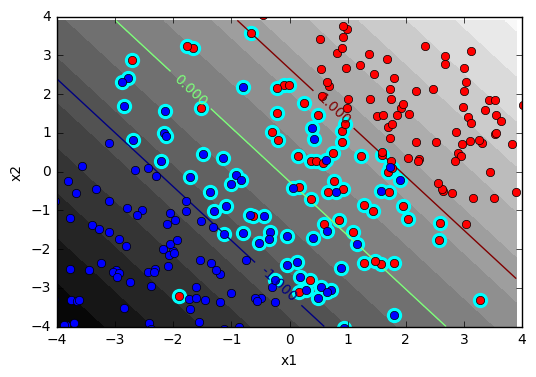

C = 0.1
Number of support vectors is equal to 61


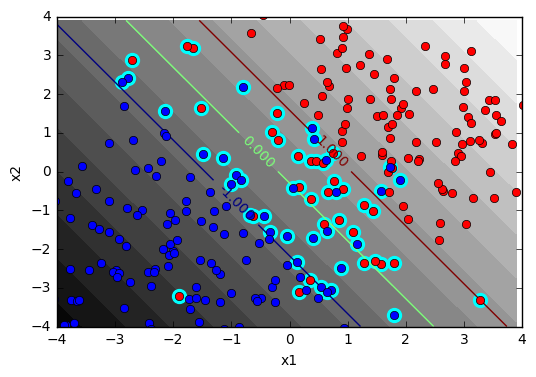

C = 1
Number of support vectors is equal to 53


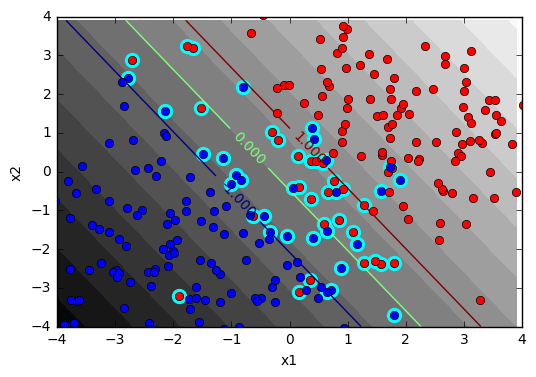

C = 100
Number of support vectors is equal to 50


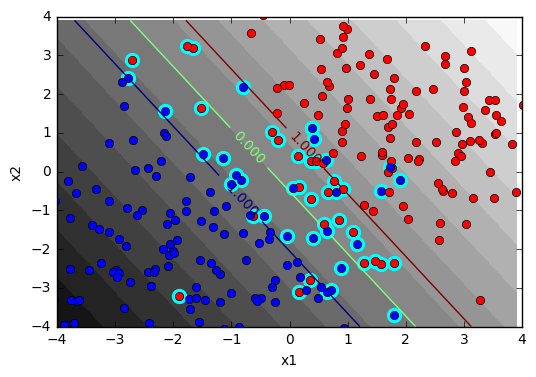

C = 1000
Number of support vectors is equal to 122


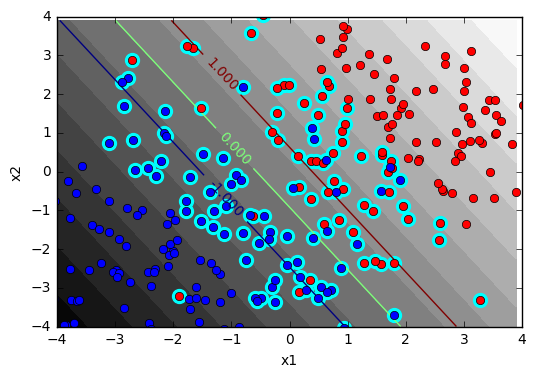

In [248]:
K = kernel(X, X)
#try for different values of C
C_values =[0.01, 0.1,1,100,1000]
for i in C_values:
    print ("C = %s" % i)
    mu_support, idx_support = svm_solver(K, y, C=i)
    b = b_non_separable(K, y, mu_support, idx_support,i)
    plot_classif(X, y, mu_support, idx_support, b)
    plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'cyan', s=100)
    plt.show()
    


- Q11: What is the influence of C on the number of support vectors? Justify this from an optimization stand point.

-------------------------------------------
C= 0.0001
Number of support vectors is equal to 300
-------------------------------------------
C= 0.0010
Number of support vectors is equal to 200
-------------------------------------------
C= 0.0100
Number of support vectors is equal to 98
-------------------------------------------
C= 0.1000
Number of support vectors is equal to 61
-------------------------------------------
C= 1.0000
Number of support vectors is equal to 53
-------------------------------------------
C= 10.0000
Number of support vectors is equal to 51
-------------------------------------------
C= 100.0000
Number of support vectors is equal to 50
-------------------------------------------
C= 1000.0000
Number of support vectors is equal to 122
-------------------------------------------
C= 10000.0000
Number of support vectors is equal to 300
-------------------------------------------
C= 1000000.0000
Number of support vectors is equal to 300


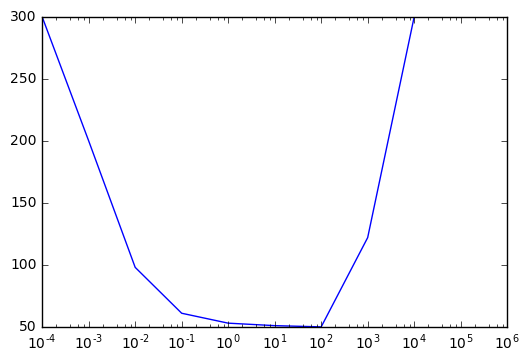

In [249]:
C_list=[1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000,1000000]
supp_vect=[]
for i in C_list:
    print("-------------------------------------------")
    print("C= %.4f" %i)
    mu_support, idx_support = svm_solver(K, y, C=i)
    supp_vect.append(idx_support.shape[0])
plt.xscale('log')
plt.plot(C_list,supp_vect)

** ANSWER Q11 **

The value of C influences the number of support vectors such that if C is too small or too high, the number of support vectors is high.
On a certain interval, the smaller the value of C, the greater the number of vector supports. Indeed, if C is too low, the regularization is strong, and the allowed margin is large.
If C is too large, we have a high penalty for nonseparable points and we may store many support vectors and overfit.  Therefore, we have to find the good trade-off.



## Part 2: non-linear case with kernels

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

- Q12: Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$

According to the previous computations ,given that $K(x_i,x_j)$, we can rewrite the dual problem as follows:
$$
\begin{cases}
\min_{\mu} \frac{1}{2} \sum_{i,j} \mu_i \mu_j y_i y_j K(x_i,x_j) - \mu ^\top u \\
y^\top \mu = 0\\
0 \leq \mu \leq C \\
\end{cases}
$$
Samely, the prediction function can be rewritten as:
$$
f(x) = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i K(x_i,x) + b) \enspace .
$$

I will use the clowns dataset to evaluate this:

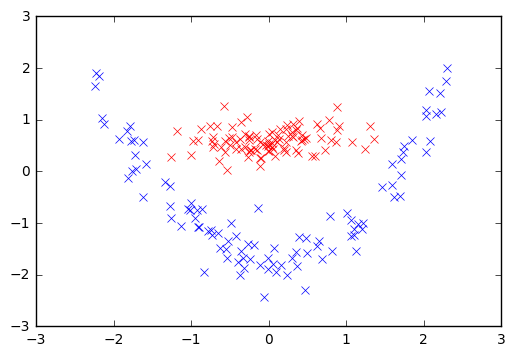

In [250]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)
plot_dataset(X, y)

- Q13: Update your kernel function so it computes the Gaussian kernel:

$$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|)
$$

where $\gamma > 0$ is the kernel bandwidth.

In [251]:
from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma*np.linalg.norm(X1[i] - X2[j]))  
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

Number of support vectors is equal to 191


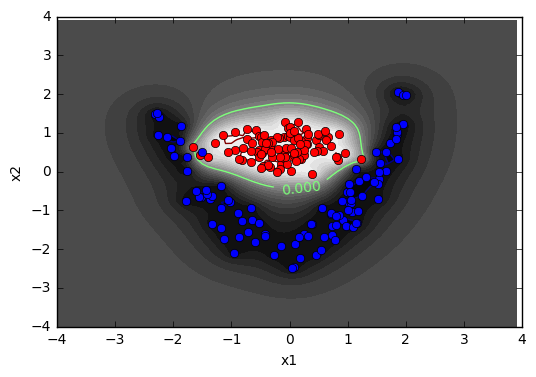

In [252]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = b_non_separable(K, y, mu_support, idx_support, C=1)

plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

## Part 3: Linear SVM without intercept

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^{t}\mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

- Q14: Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$

** ANSWER Q14 **

We write the Lagrangian as follows:

The Lagrangian $\mathcal{L}(w, \mu, \xi, \alpha)$ = $\frac{1}{2}w^{\top}w + C \sum_i \xi_i + \sum_{i=1}^{n} \mu_i[- y_{i}(w^{\top}x_{i}) + 1 - \xi_{i}] - \sum_i \alpha_i \xi_i$ where $\mu_i \geq 0$ and $\alpha_i \geq 0 \quad \forall i\in \{1,\cdots,n\} $

$\mu_i \geq 0 $ ,therefore, $\mu \geq 0$

By deriving with respect to the two variables, we obtain:

$$
\left\{
  \begin{array}{cll}
  &\frac{d\mathcal{L}(w, \mu, \xi, \alpha)}{dw} = w + \sum_{i=1}^{n} -\mu_iy_{i}x_{i} = 0 \;\;\;\;\; (1)
  \\
   & \frac{d\mathcal{L}(w, \mu, \xi, \alpha)}{d\xi_{i}} = C - \alpha_{i} - \mu_{i} = 0 \;\;\;\;\;\;\; \;\;\; \;\;(2)
  \end{array}
  \right.
$$


From (1), we deduce that $w = \sum_{i=1}^{n} \mu_iy_{i}x_{i}$. It implies $w = G^{\top}\mu$ where $G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}$ and $\mu = \begin{bmatrix} \mu_{1} \\ \vdots \\ \mu_{n}\end{bmatrix}$

From (2), we deduce that $ \mu_{i} = C - \alpha_{i}$. Moreover $\alpha_{i} \geq 0 $ then $\mu_{i} \leq C $. Therefore, $0 \leq \mu \leq C$ 


Back to the lagrangian expression, we have:

$$\mathcal{L}(w, \mu, \xi, \alpha) = \frac{1}{2}w^{\top}w + C \sum_i \xi_i + \sum_{i=1}^{n} \mu_i[- y_{i}(w^{\top}x_{i}) + 1 - \xi_{i}] - \sum_i \alpha_i \xi_i$$

$$\mathcal{L}(w, \mu, \xi, \alpha) = \frac{1}{2}w^{\top}w - \sum_{i=1}^{n} \mu_i y_{i}w^{\top}x_{i} + \sum_{i=1}^{n} \mu_i + \sum_{i}^{n} \xi_{i}(C - \mu_{i} - \alpha_{i})$$

Given that $ \mu_{i} = C - \alpha_{i}$, we also have $$\mathcal{L}(w, \mu, \xi, \alpha) = \frac{1}{2}w^{\top}w - \sum_{i=1}^{n} \mu_i y_{i}w^{\top}x_{i} - \sum_{i=1}^{n} \mu_i y_{i}b + \sum_{i=1}^{n} \mu_i $$

By replacing $w = \sum_{i=1}^{n} \mu_iy_{i}x_{i}$ in $\mathcal{L}(w, \mu, \xi, \alpha)$, we obtain:

$$\mathcal{L}(\mu) =  \frac{1}{2}w^{\top}w - w^{\top}w + \sum_{i=1}^{n} \mu_i $$


Therefore $$\mathcal{L}(\mu) = - \frac{1}{2}\mu^{\top}GG^{\top}\mu + \mu^{\top} 1_n 
where 1_n = (1, \dots, 1) \in \mathbb{R}^n $$

Thus, the problem in the dual can be rewritten as follows :


$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$

- Q15: Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$

** Answer Q15 **

We have the problem in the dual
$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$



We pose f and g such that: 
- $$f(\mu) = \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top 1_n  \;\;\;\;\;\; thus \;\;\;  \nabla^2 f(\mu) = GG^T$$
f is convex and smooth with the L-lipshitz equal to:
$$
L = \| G G^\top 
\|_{op}
$$

- $$
g(\mu) = \sum_{i=1}^n g_i (\mu_i)
$$
where
$$
g_i(\mu_i) = \mathbb{I}_{[0,C]}(\mu_i) = 
\begin{cases}
0, \quad \text{if } \mu_i \in [0,C] \\
+\infty, \quad \text{if } \mu_i \not \in [0,C]
\end{cases}
$$
Therefore the problem $(\mathcal{D})$ is now:
$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu).
$$



The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

- Q16: Implement:

   - your own version of proximal gradient with and without acceleration
   - your own version of coordinate descent
   - an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to abscence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You will test your implementations on the Gaussian blobs and evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is the most important and will constitute half of the final grade on the project !**

### Useful functions and classes for all methods

We define a class SVM where we define functions used for the 4 methods and that minimize the problem mentionned just previously.

In [272]:
from scipy.linalg import svd
from scipy.linalg import norm

class Svm(object):

    def __init__(self, X, y, c):
        self.X = X
        self.y = y
        self.c = c
        K = kernel(X, X)
        self.H = (y * K).T * y
        self.n = y.shape[0]
        self.e = np.ones(self.n)  
    
    def g(self, x):
        """ Indicator function of [0, C] """
        if np.any(x < 0):
            return np.inf
        if not np.isinf(self.c):
            if np.any(x > self.c):
                return np.inf
        return 0

    def prox_g(self, x):
        """ projection on [0, C] : max(0, min(x, C)) """
        if(x.shape):
            res = x.copy()
            if not np.isinf(self.c):
                res[x > self.c] = self.c
                res[x < 0] = 0
            else: 
                res[x < 0] = 0
            return res
        else:
            if not np.isinf(self.c):
                res = max(0, min(x, self.c))
            else:
                res = max(0, x)
            return res
        
    def loss(self, x):
        return 1. / 2 * x.dot(self.H.dot(x)) - x.dot(self.e) + self.g(x)
    
    #loss for the lbfgs_B method
    def loss_smooth(self, x):
        return 1. / 2 * x.dot(self.H.dot(x)) - x.dot(self.e)
    
    def grad(self, x):
        return self.H.dot(x) - self.e
    
    def lipschitz_constant(self):
        return norm(self.H, ord=2)
    
    
    '''Functions to implement smart coordinate'''
    def grad_i(self, x, i):
        return np.dot((self.H)[:, i], x) - (self.e)[i]
    
    def grad_i_2(self, w, i):
        return self.y[i] * np.dot(w, X[i, :]) - 1
    
    def get_w(self, x):
        return np.sum( (self.y * x)[:, None] * self.X, axis=0)
    
    def update_w(self, x_i_old, x_i, old_w, i):
        return old_w + (x_i - x_i_old) * self.y[i] * self.X[i, :]
    
    def lipschitz_i(self):
        return np.diagonal(self.H)

   

In [273]:
def get_support_vec(mu):
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

def compute_w_b(mu, y, X):
    mu_support, idx_support = get_support_vec(mu)
    w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)
    return w[:-1], w[2]

In [274]:
from scipy.linalg import norm
import time
def inspector(loss_fun, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    durations = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) #- f_min
        err = norm(xk - x_min)
        objectives.append(obj)
        dur = time.clock() - cur
        durations.append(dur)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err","dur"]])) #"err"
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8),("%.2e" % dur).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.dur = durations
    inspector_cl.err = errors
    return inspector_cl

### Use QP_solver to get f_min

In [275]:
def QP(H, e, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    e = cvxopt.matrix(-e)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

### Data Generation 

In [276]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
c = 0.5
model = Svm(X, y, c)

### Compute f_min with QP solver

In [277]:
x_min = np.zeros(model.n)
x_min = QP(model.H, model.e, c, l=1e-8, verbose=False)
f_min = model.loss(x_min)
print(f_min)

-15.9681541164


### ISTA 

In [278]:
def ista(x_init, grad, prox, n_iter, step, callback=None):
    x = x_init.copy()
    
    for _ in range(n_iter):
        x = prox(x - step * grad(x))   
        # Update metrics after each iteration.
        if callback: 
            callback(x)
    return x

   it    |   obj    |   err    |   dur   
       0 | -7.46e-02 | 2.89e+00 | 5.90e+00
      40 | -8.65e-01 | 2.80e+00 | 5.91e+00
      80 | -1.52e+00 | 2.71e+00 | 5.93e+00
     120 | -2.16e+00 | 2.63e+00 | 5.94e+00
     160 | -2.80e+00 | 2.55e+00 | 5.96e+00
Number of support vectors for n_iter=200: 93
   it    |   obj    |   err    |   dur   
       0 | -7.46e-02 | 2.89e+00 | 7.59e+00
    4000 | -1.59e+01 | 4.30e-01 | 8.53e+00
    8000 | -1.59e+01 | 2.03e-01 | 9.46e+00
   12000 | -1.60e+01 | 8.67e-02 | 1.05e+01
   16000 | -1.60e+01 | 9.61e-04 | 1.14e+01
Number of support vectors for n_iter=20000: 35


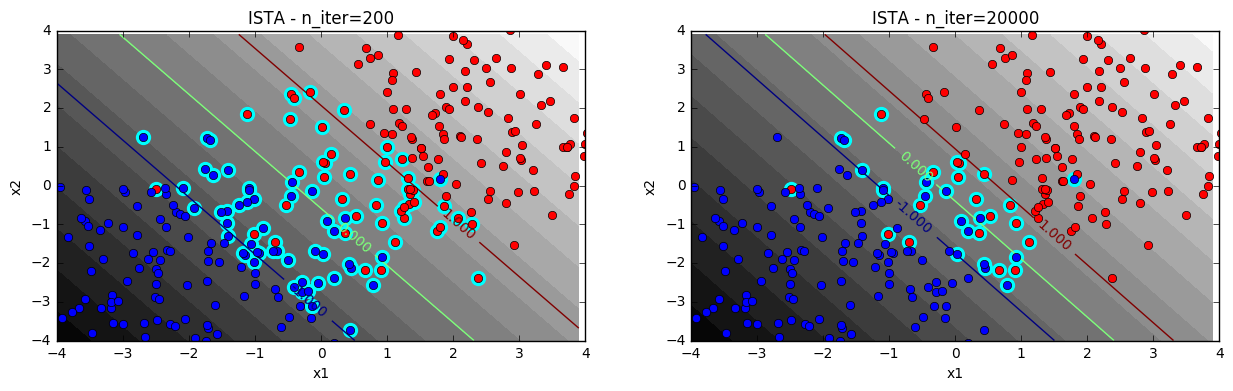

In [279]:
step = 1. / model.lipschitz_constant()
plt.figure(figsize=(15,4))
for k,n_iter in enumerate([200,20000]):
    x_init = np.zeros(model.n)
    ista_inspector = inspector(model.loss, verbose=True)
    x_ista = ista(x_init, model.grad, model.prox_g, n_iter, step, callback=ista_inspector)
    mu_support, idx_support = get_support_vec(x_ista)
    _, b = compute_w_b(x_ista, y, X)
    print("Number of support vectors for n_iter=%d: %s" % (n_iter,idx_support.size))
    plt.subplot(1,2,k+1)
    plot_classif(X[:, :-1], y, mu_support, idx_support, b)
    plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'cyan', s=100)
    plt.title("ISTA - n_iter=%d" %n_iter)
plt.show()

### FISTA

In [280]:
def fista(x_init, grad, prox, n_iter, step, callback=None):
    x = x_init.copy()
    y = x_init.copy() 
    t = 1.

    for _ in range(n_iter):
        x_new = prox(y - step * grad(x))
        t_new = (1. + np.sqrt(1 + 4 * t * t)) / 2
        y = x_new + (t - 1) / t_new * (x_new - x)
        x = x_new
        t = t_new
    
        # Update metrics after each iteration.
        if callback: 
            callback(x)
    return x

   it    |   obj    |   err    |   dur   
       0 | -7.46e-02 | 2.89e+00 | 1.42e+01
      40 | -4.11e+00 | 2.38e+00 | 1.42e+01
      80 | -1.22e+01 | 1.37e+00 | 1.42e+01
     120 | -1.54e+01 | 7.65e-01 | 1.42e+01
     160 | -1.58e+01 | 4.99e-01 | 1.43e+01
Number of support vectors for n_iter=200: 40
   it    |   obj    |   err    |   dur   
       0 | -7.46e-02 | 2.89e+00 | 1.52e+01
    4000 | -1.60e+01 | 2.47e-04 | 1.62e+01
    8000 | -1.60e+01 | 1.37e-04 | 1.72e+01
   12000 | -1.60e+01 | 1.05e-04 | 1.82e+01
   16000 | -1.60e+01 | 7.22e-05 | 1.92e+01
Number of support vectors for n_iter=20000: 35


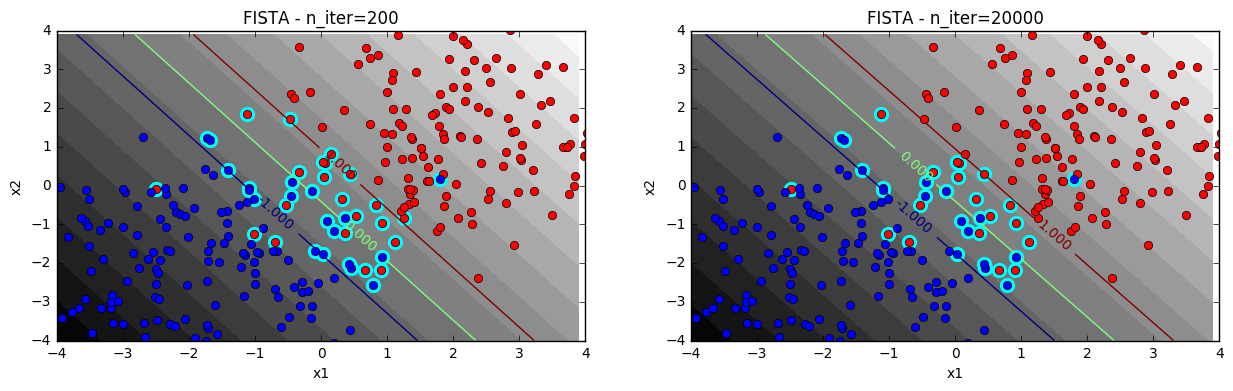

In [281]:
step = 1. / model.lipschitz_constant()

plt.figure(figsize=(15,4))
for k,n_iter in enumerate([200,20000]):
    x_init = np.zeros(model.n)
    fista_inspector = inspector(model.loss, verbose=True)
    x_fista = fista(x_init, model.grad, model.prox_g, n_iter, step, callback=fista_inspector)
    mu_support, idx_support = get_support_vec(x_fista)
    _, b = compute_w_b(x_fista, y, X)
    print("Number of support vectors for n_iter=%d: %s" % (n_iter,idx_support.size))
    plt.subplot(1,2,k+1)
    plot_classif(X[:, :-1], y, mu_support, idx_support, b)
    plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'cyan', s=100)
    plt.title("FISTA - n_iter=%d" %n_iter)
plt.show()

### ISTA and FISTA comparison

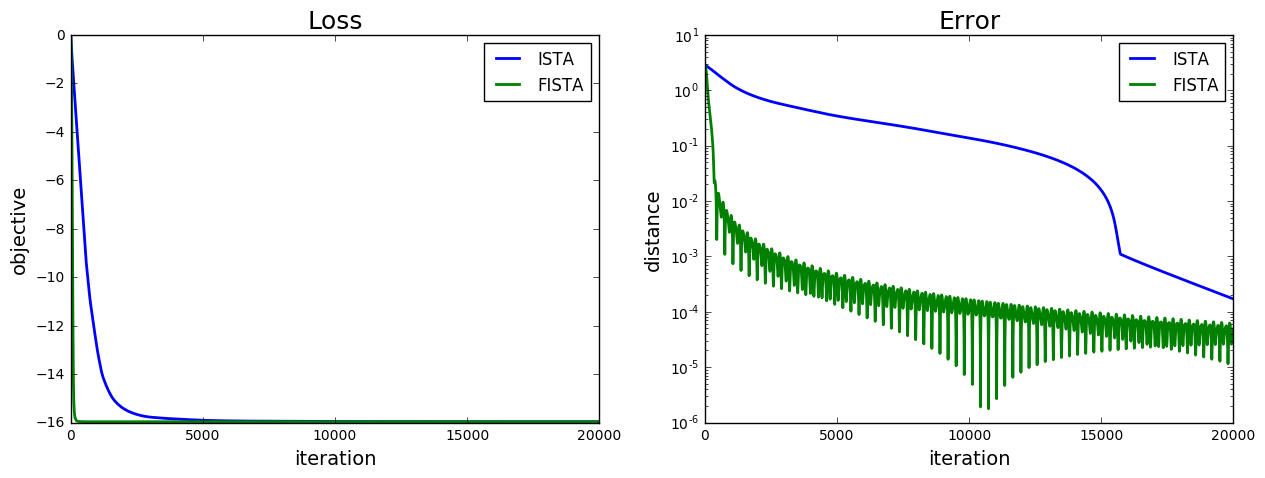

In [282]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
insp = [ista_inspector, fista_inspector]
solvers = ["ISTA", "FISTA"]

for i in insp:
    plt.plot(i.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
plt.legend(solvers)

plt.subplot(1, 2, 2)
for i in insp:
    plt.plot(i.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")
plt.legend(solvers);


In [283]:
### Smart coordinate descent

In [284]:
def smart_cd(x_init, n, grad, get_w, update_w, H, prox, n_iter=100, step=1., callback=None):
    x = x_init.copy()
    w = get_w(x)
    for k in range(n_iter):
        i = k % n
        xi_old = x[i]
        grad_i = grad(w, i)
        x[i] = prox(x[i] - step[i] * grad_i)
        w = update_w(xi_old, x[i], w, i)
        
        if callback: 
            callback(x)
    return x

   it    |   obj    |   err    |   dur   
       0 | -8.16e-02 | 2.89e+00 | 2.33e+01
      80 | -4.48e-01 | 2.81e+00 | 2.33e+01
     160 | -1.04e+00 | 2.77e+00 | 2.33e+01
     240 | -1.56e+00 | 2.63e+00 | 2.34e+01
     320 | -3.06e+00 | 2.60e+00 | 2.34e+01
Number of support vectors for n_iter=400: 23
   it    |   obj    |   err    |   dur   
       0 | -8.16e-02 | 2.89e+00 | 2.43e+01
    8000 | -1.59e+01 | 3.94e-01 | 2.57e+01
   16000 | -1.60e+01 | 5.78e-07 | 2.72e+01
   24000 | -1.60e+01 | 5.78e-07 | 2.87e+01
   32000 | -1.60e+01 | 5.78e-07 | 3.01e+01
Number of support vectors for n_iter=40000: 35


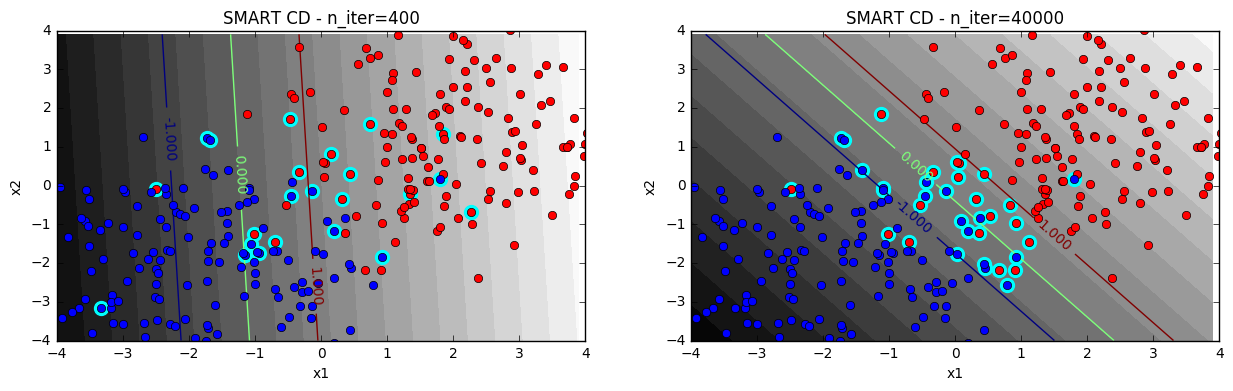

In [285]:
plt.figure(figsize=(15,4))
for k, n_iter in enumerate([400, 40000]):
    x_init = np.zeros(model.n)
    smart_cd_inspector = inspector(model.loss, verbose=True)
    x_smart_cd = smart_cd(x_init, model.n, model.grad_i_2, model.get_w, model.update_w, 
                           model.H, model.prox_g, n_iter,  1. / model.lipschitz_i(), callback=smart_cd_inspector)
    mu_support, idx_support = get_support_vec(x_smart_cd)
    _, b = compute_w_b(x_smart_cd, y, X)
    print("Number of support vectors for n_iter=%d: %s" % (n_iter,idx_support.size))
    plt.subplot(1,2,k+1)
    plot_classif(X[:, :-1], y, mu_support, idx_support, b)
    plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'cyan', s=100)
    plt.title("SMART CD - n_iter=%d" %n_iter)
plt.show()

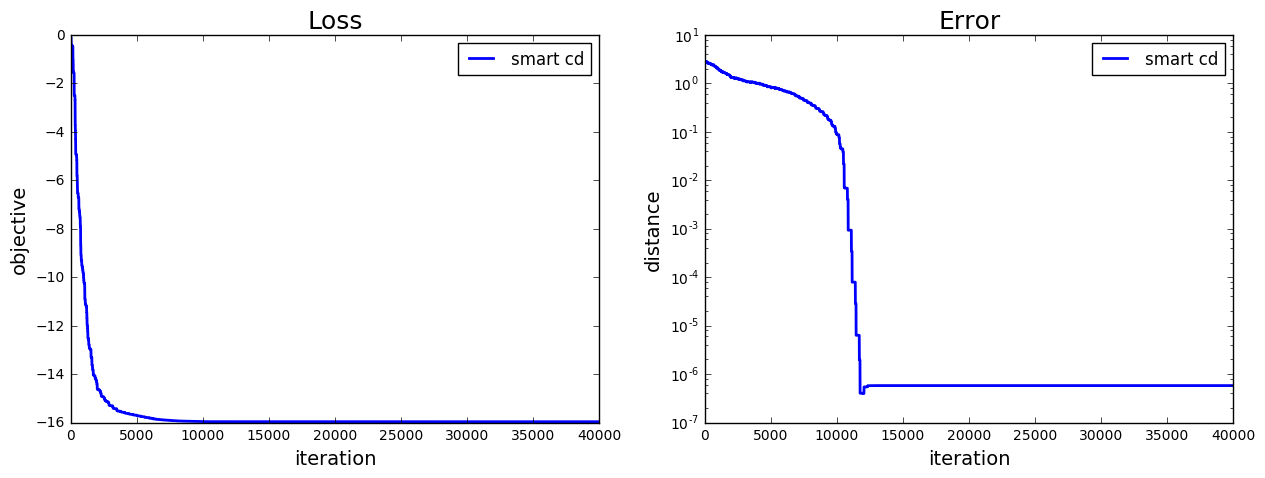

In [286]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
insp = [smart_cd_inspector]
solvers = ["smart cd"]

for i in insp:
    plt.plot(i.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
plt.legend(solvers)

plt.subplot(1, 2, 2)
for i in insp:
    plt.plot(i.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")
plt.legend(solvers);

### LBFGS_B

   it    |   obj    |   err    |   dur   
       0 | -8.03e-02 | 2.89e+00 | 5.64e-03
      40 | -1.57e+01 | 5.83e-01 | 3.86e-02
      80 | -1.60e+01 | 1.06e-01 | 6.68e-02
     120 | -1.60e+01 | 7.38e-03 | 9.95e-02
Number of support vectors for n_iter=200: 35


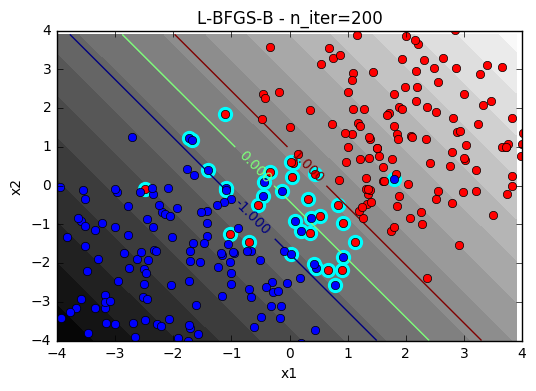

In [287]:
from scipy.optimize import fmin_l_bfgs_b
n_iter = 200
x_init = np.zeros(model.n)
bounds = [(0, c) for i in range(model.n)]
scipy_l_bfgs_b_inspector = inspector(model.loss, verbose=True)
cur = time.clock()
x_lbfgs, f_lbfgs, _ = fmin_l_bfgs_b(model.loss, x_init, fprime=model.grad, factr=10., bounds=bounds, maxiter=n_iter, callback=scipy_l_bfgs_b_inspector)
mu_support, idx_support = get_support_vec(x_lbfgs)
_, b = compute_w_b(x_smart_cd, y, X)
print("Number of support vectors for n_iter=%d: %s" % (n_iter,idx_support.size))
plot_classif(X[:, :-1], y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'cyan', s=100)
plt.title("L-BFGS-B - n_iter=%d" %n_iter)

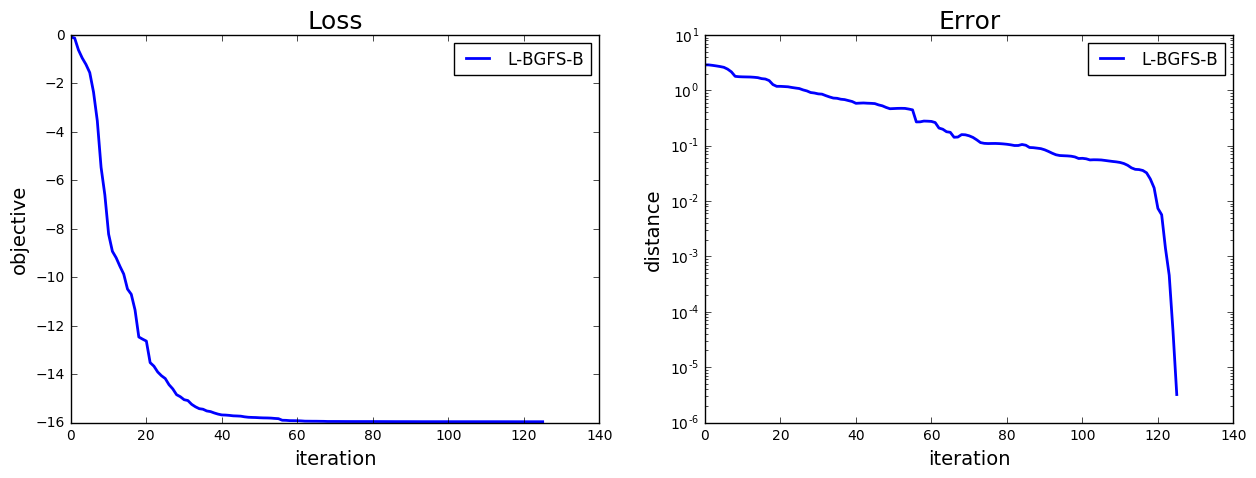

In [288]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
insp = [scipy_l_bfgs_b_inspector]
solvers = ["L-BGFS-B"]

for i in insp:
    plt.plot(i.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
plt.legend(solvers)

plt.subplot(1, 2, 2)
for i in insp:
    plt.plot(i.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")
plt.legend(solvers);

## Visualization for different datasizes

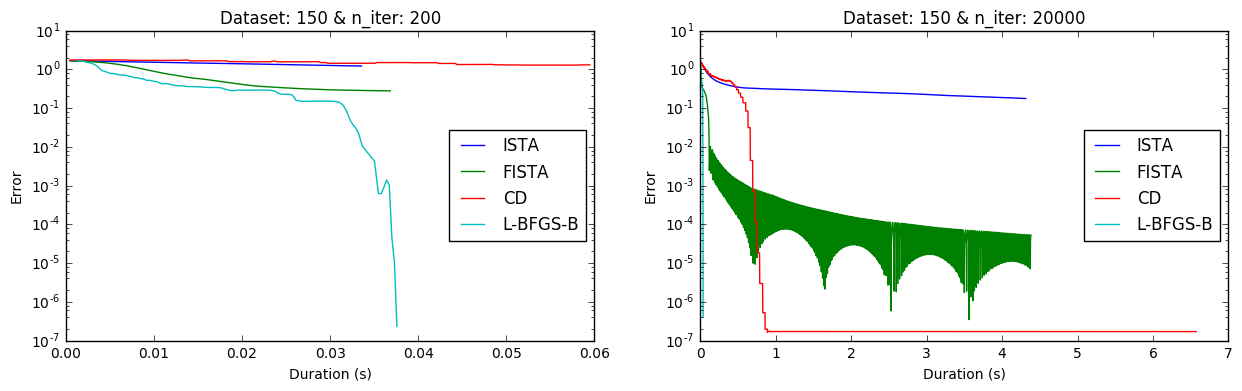

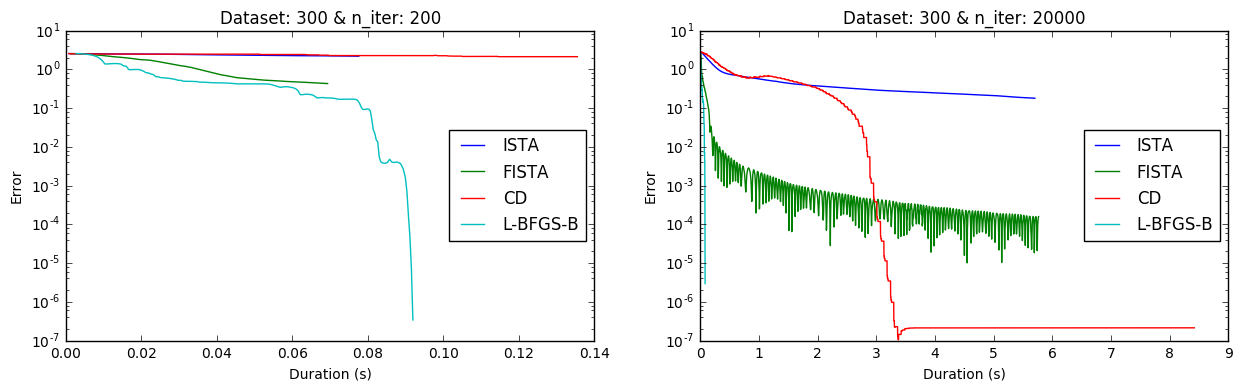

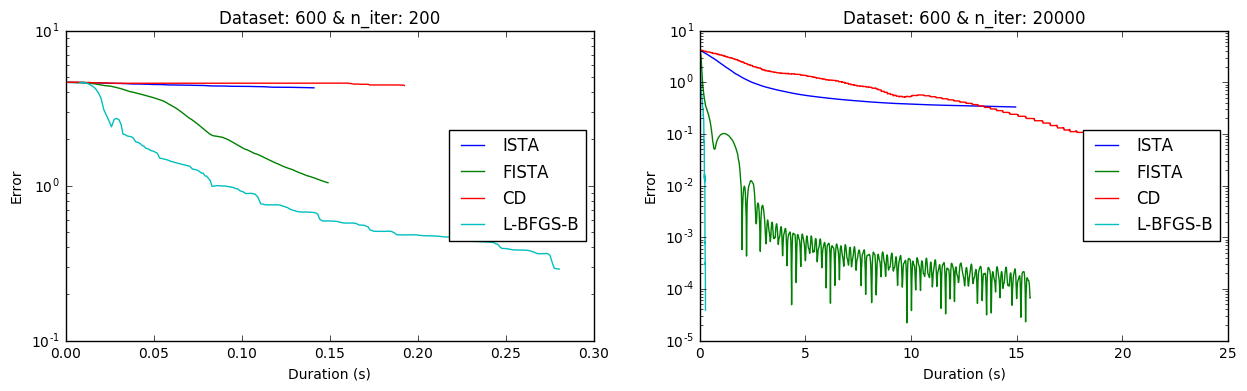

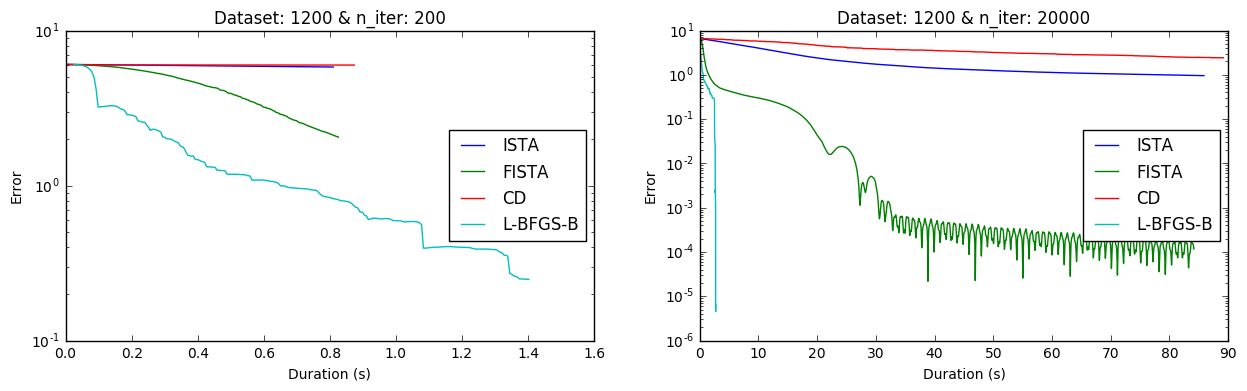

In [289]:
for N in [150,300,600,1200]:
    plt.figure(figsize=(15, 4))
    for pos,n_iter in enumerate([200, 20000]):
        X, y = datasets(name='gaussian', n_points=N, sigma=1.5)
        X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
        c = 0.5
        model = Svm(X, y, c)
        x_min = np.zeros(model.n)
        x_min = QP(model.H, model.e, c, l=1e-8, verbose=False)
        f_min = model.loss(x_min)

        step = 1. / model.lipschitz_constant()
        x_init = np.zeros(model.n)

        ista_inspector = inspector(model.loss, verbose=False)
        cur = time.clock()
        x_ista = ista(x_init, model.grad, model.prox_g, n_iter, step, callback=ista_inspector)

        fista_inspector = inspector(model.loss, verbose=False)
        cur = time.clock()
        x_fista = fista(x_init, model.grad, model.prox_g, n_iter, step, callback=fista_inspector)

        smart_cd_inspector = inspector(model.loss, verbose=False)
        cur = time.clock()
        x_smart_cd = smart_cd(x_init, model.n, model.grad_i_2, model.get_w, model.update_w, 
                           model.H, model.prox_g, n_iter*2,  1. / model.lipschitz_i(), callback=smart_cd_inspector)

        bounds = [(0, c) for i in range(model.n)]
        scipy_l_bfgs_b_inspector = inspector(model.loss, verbose=False)
        cur = time.clock()
        x_lbfgs, f_lbfgs, _ = fmin_l_bfgs_b(model.loss, x_init, fprime=model.grad, factr=10., bounds=bounds, maxiter=n_iter, callback=scipy_l_bfgs_b_inspector)
        
        plt.subplot(1,2,pos+1)
        plt.plot(ista_inspector.dur, ista_inspector.err, label="ISTA")
        plt.plot(fista_inspector.dur, fista_inspector.err, label="FISTA")
        plt.plot(smart_cd_inspector.dur, smart_cd_inspector.err, label="CD")
        plt.plot(scipy_l_bfgs_b_inspector.dur, scipy_l_bfgs_b_inspector.err, label="L-BFGS-B")
        plt.legend(loc='center right')
        plt.xlabel("Duration (s)")
        plt.ylabel("Error")
        plt.yscale('log')
        plt.title("Dataset: %d & n_iter: %d" %(N, n_iter))
    plt.show()        

** Observations and comments **

- I first used the QP solver to get the true minimum. I then implemented the four algorithms and computed the error by substracting the true minimum found with the QP solver.
- As expected from the previous TPs, we get:
    - ISTA presents a linear convergence $O(1/k)$ and is a descent algorithm. 
    - FISTA is much faster and has a $O(1/k^2)$ convergence but is not descent, it presents bumps.
    - Smart coordinate descent allows to converge much more rapidly than coordiante descent without the smart updates.We notice that smart coordinates desent and ISTA give almost the same result whathever the size of the dataset except when the number of iterations is very high, in which case smart coordinate descent is more performant than ISTA.
    - Lbfgs-B gives the best result whithin a low number of iterations.

- All the four algorithms converge and give results with a given precision. They can be easily adapted for a matrix H too big.